In [7]:
import requests
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from scipy.stats import stats

import time

# Game Data

## Creating function to request data 

In [60]:
def get_game_data(per_page=100, total_pages=None):

    # Get the last page from the meta data
    url = 'https://www.balldontlie.io/api/v1/games'
    parameters = {'per_page': per_page, 'page': 1}
    resp = requests.get(url, params = parameters).json()
    total_pages = resp['meta']['total_pages'] if total_pages is None else total_pages
    
    # Initialize data frame 
    game_data = pd.DataFrame()
    
    start_time = time.time()
    
    # Loop to iterate through all pages
    for page in range(1, total_pages+1):
        
        # Making the request
        url = 'https://www.balldontlie.io/api/v1/games'
        parameters = {'per_page': per_page, 'page': page}
        resp = requests.get(url, params = parameters).json()

        # Creating dataframe from the data key
        data = pd.DataFrame.from_records(resp['data'])

        # Creating columns out of the 'home_team' and 'visitor_team' column (these columns had dictionary values)
        for k in data['home_team'][0].keys():
            data['home_'+k] = data['home_team'].apply(lambda x: x[k])
        for k in data['visitor_team'][0].keys():
            data['visitor_'+k] = data['visitor_team'].apply(lambda x: x[k])
        
        # Column to display which page results came from
        data['Page'] = page
        
        # Concatenate our initial datafram with dataframe from each loop
        game_data = pd.concat([game_data, data])
        
        # Delay between requests
        time.sleep(0.8)
    
    # Convert the date column to date (dt.tz_localize is used to remove toe T-Z string)
    game_data['date'] = pd.to_datetime(game_data['date'], errors='coerce').dt.tz_localize(None)
    
    end_time = time.time()
    print(end_time - start_time)
    
    return game_data

In [61]:
game_data = get_game_data(per_page=100, total_pages=5)
#game_data = get_game_data()

6.004288673400879


In [62]:
game_data.head()

,date,home_team,home_team_score,id,period,postseason,season,status,time,visitor_team,...,home_full_name,home_name,visitor_id,visitor_abbreviation,visitor_city,visitor_conference,visitor_division,visitor_full_name,visitor_name,Page
0,2019-01-30,"{'id': 2, 'abbreviation': 'BOS', 'city': 'Bost...",126,47179,4,False,2018,Final,,"{'id': 4, 'abbreviation': 'CHA', 'city': 'Char...",...,Boston Celtics,Celtics,4,CHA,Charlotte,East,Southeast,Charlotte Hornets,Hornets,1
1,2019-02-09,"{'id': 2, 'abbreviation': 'BOS', 'city': 'Bost...",112,48751,4,False,2018,Final,,"{'id': 13, 'abbreviation': 'LAC', 'city': 'LA'...",...,Boston Celtics,Celtics,13,LAC,LA,West,Pacific,LA Clippers,Clippers,1
2,2019-02-08,"{'id': 23, 'abbreviation': 'PHI', 'city': 'Phi...",117,48739,4,False,2018,Final,,"{'id': 8, 'abbreviation': 'DEN', 'city': 'Denv...",...,Philadelphia 76ers,76ers,8,DEN,Denver,West,Northwest,Denver Nuggets,Nuggets,1
3,2019-02-08,"{'id': 30, 'abbreviation': 'WAS', 'city': 'Was...",119,48740,4,False,2018,Final,,"{'id': 6, 'abbreviation': 'CLE', 'city': 'Clev...",...,Washington Wizards,Wizards,6,CLE,Cleveland,East,Central,Cleveland Cavaliers,Cavaliers,1
4,2019-02-08,"{'id': 26, 'abbreviation': 'SAC', 'city': 'Sac...",102,48746,4,False,2018,Final,,"{'id': 16, 'abbreviation': 'MIA', 'city': 'Mia...",...,Sacramento Kings,Kings,16,MIA,Miami,East,Southeast,Miami Heat,Heat,1


## Creating function to shape dataframe

id, East Score, West Score

In [64]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 99
Data columns (total 26 columns):
date                    500 non-null datetime64[ns]
home_team               500 non-null object
home_team_score         500 non-null int64
id                      500 non-null int64
period                  500 non-null int64
postseason              500 non-null bool
season                  500 non-null int64
status                  500 non-null object
time                    500 non-null object
visitor_team            500 non-null object
visitor_team_score      500 non-null int64
home_id                 500 non-null int64
home_abbreviation       500 non-null object
home_city               500 non-null object
home_conference         500 non-null object
home_division           500 non-null object
home_full_name          500 non-null object
home_name               500 non-null object
visitor_id              500 non-null int64
visitor_abbreviation    500 non-null object
visitor_city     

In [65]:
def reshape_data(data):
    
    data['East_Score'] = np.where(data['home_conference']=="East", data['home_team_score'], data['visitor_team_score'])
    data['West_Score'] = np.where(data['home_conference']=="West", data['home_team_score'], data['visitor_team_score'])
    
    data = data[['id', 'East_Score', 'West_Score']]
    return data

In [66]:
game_data_reshaped = reshape_data(game_data)

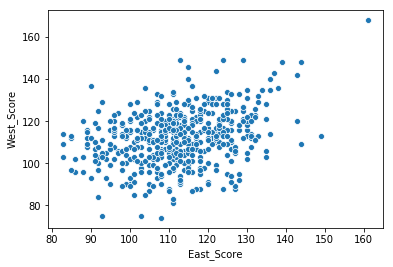

In [69]:
sns.scatterplot(data=game_data_reshaped, x='East_Score', y='West_Score')

## Create regression function

In [68]:
X = game_data_reshaped['East_Score']
y = game_data_reshaped['West_Score']
X = sm.add_constant(X)
mod = sm.OLS(y, X, hasconst= True)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             West_Score   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     61.53
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           2.67e-14
Time:                        11:02:51   Log-Likelihood:                -1954.8
No. Observations:                 500   AIC:                             3914.
Df Residuals:                     498   BIC:                             3922.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.3464      4.980     14.728      0.0

C:\Users\anees\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
